In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. 데이터 불러오기



In [1]:
!pip install cpi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.3/30.3 MB 36.9 MB/s eta 0:00:00


In [2]:
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import cpi
from datetime import date
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

/usr/local/lib/python3.10/dist-packages/cpi/__init__.py:42: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  warnings.warn(StaleDataWarning())


In [3]:
# KPSS 검정을 수행할 함수 정의
def kpss_test(x, h0_type='c'):
    '''
    Function for performing the Kwiatkowski-Phillips-Schmidt-Shin test for stationarity

    Null Hypothesis: time series is stationary
    Alternate Hypothesis: time series is not stationary

    Parameters
    ----------
    x: pd.Series / np.array
        The time series to be checked for stationarity
    h0_type: str{'c', 'ct'}
        Indicates the null hypothesis of the KPSS test:
            * 'c': The data is stationary around a constant(default)
            * 'ct': The data is stationary around a trend
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the KPSS test's results
    '''
    
    indices = ['Test Statistic', 'p-value', '# of Lags']

    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)
    
    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value

    return results

In [4]:
# ADF 테스트를 수행할 함수 정의
def adf_test(x):
    '''
    Function for performing the Augmented Dickey-Fuller test for stationarity
    
    Null Hypothesis: time series is not stationary
    Alternate Hypothesis: time series is stationary

    Parameters
    ----------
    x : pd.Series / np.array
        The time series to be checked for stationarity
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the ADF test's results
    '''
    
    indices = ['Test Statistic', 'p-value',
               '# of Lags Used', '# of Observations Used']
    
    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)
    
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value

    return results

In [5]:
def test_autocorrelation(x, n_lags=40, alpha=0.05, h0_type='c'):
    '''
    Function for testing the stationarity of a series by using:
    * the ADF test
    * the KPSS test
    * ACF/PACF plots
    Parameters
    ----------
    x: pd.Series / np.array
        The time series to be checked for stationarity
    n_lags : int
        The number of lags for the ACF/PACF plots
    alpha : float
        Significance level for the ACF/PACF plots
    h0_type: str{'c', 'ct'}
        Indicates the null hypothesis of the KPSS test:
            * 'c': The data is stationary around a constant(default)
            * 'ct': The data is stationary around a trend
    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure containing the ACF/PACF plot
    '''

    adf_results = adf_test(x)
    kpss_results = kpss_test(x, h0_type=h0_type)

    print('ADF test statistic: {:.2f} (p-val: {:.2f})'.format(adf_results['Test Statistic'],
                                                             adf_results['p-value']))
    print('KPSS test statistic: {:.2f} (p-val: {:.2f})'.format(kpss_results['Test Statistic'],
                                                              kpss_results['p-value']))

    fig, ax = plt.subplots(2, figsize=(16, 8))
    plot_acf(x, ax=ax[0], lags=n_lags, alpha=alpha)
    plot_pacf(x, ax=ax[1], lags=n_lags, alpha=alpha)

    return fig


In [8]:
# 파일 경로
file_path = "/content/drive/MyDrive/🐹전종설🐹/코드/유진티비/Time Series Modeling/df_time_series.csv"

# 인코딩 방식 리스트
encodings = ['utf-8', 'euc-kr', 'latin1']

# 각 인코딩 방식으로 파일 열기 시도
df = None
for encoding in encodings:
    try:
        df = pd.read_csv(file_path, encoding=encoding)
        break
    except UnicodeDecodeError:
        continue

# 파일 열기 성공 여부 확인
if df is None:
    print("파일 열기에 실패했습니다.")
else:
    print("파일 열기 성공!")

df.head(5)

파일 열기 성공!


,일자,배출권 가격(종가)
0,2015-01-12,8640
1,2015-01-13,9500
2,2015-01-14,9510
3,2015-01-15,9580
4,2015-01-16,9610


## 2. ARIMA 모델링
- 시계열 데이터를 분석, 예측하는 통계 모델 클래스
- 데이터의 자기 상관을 설명하는 방법 사용


In [ ]:
! pip install pmdarima

In [30]:
from pmdarima.model_selection import train_test_split

# train/validation 데이터 나누기
df_train = df[df.일자 < '2021-01-01']
df_test = df[df.일자 >= '2021-01-01']

# 각 데이터의 사이즈 확인
print("Train set Shape", df_train.shape)
print("Test set Shape", df_test.shape)

Train set Shape (1469, 2)
Test set Shape (494, 2)


In [31]:
df_train.set_index('일자', inplace=True)
df_test.set_index('일자', inplace=True)

<Axes: >

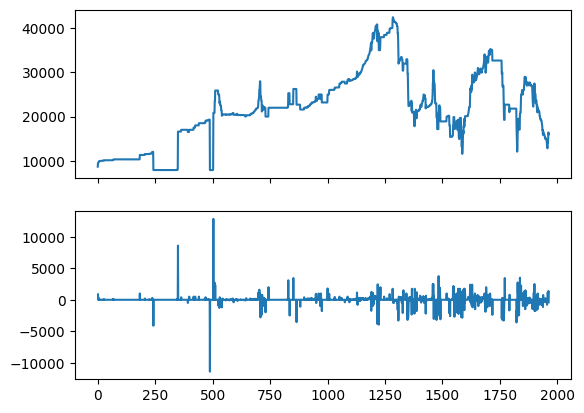

In [32]:
diff = df['배출권 가격(종가)'].diff().dropna()

fig, ax = plt.subplots(2, sharex=True)
df['배출권 가격(종가)'].plot(ax=ax[0])
diff.plot(ax=ax[1])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


ADF test statistic: -13.19 (p-val: 0.00)
KPSS test statistic: 0.12 (p-val: 0.10)


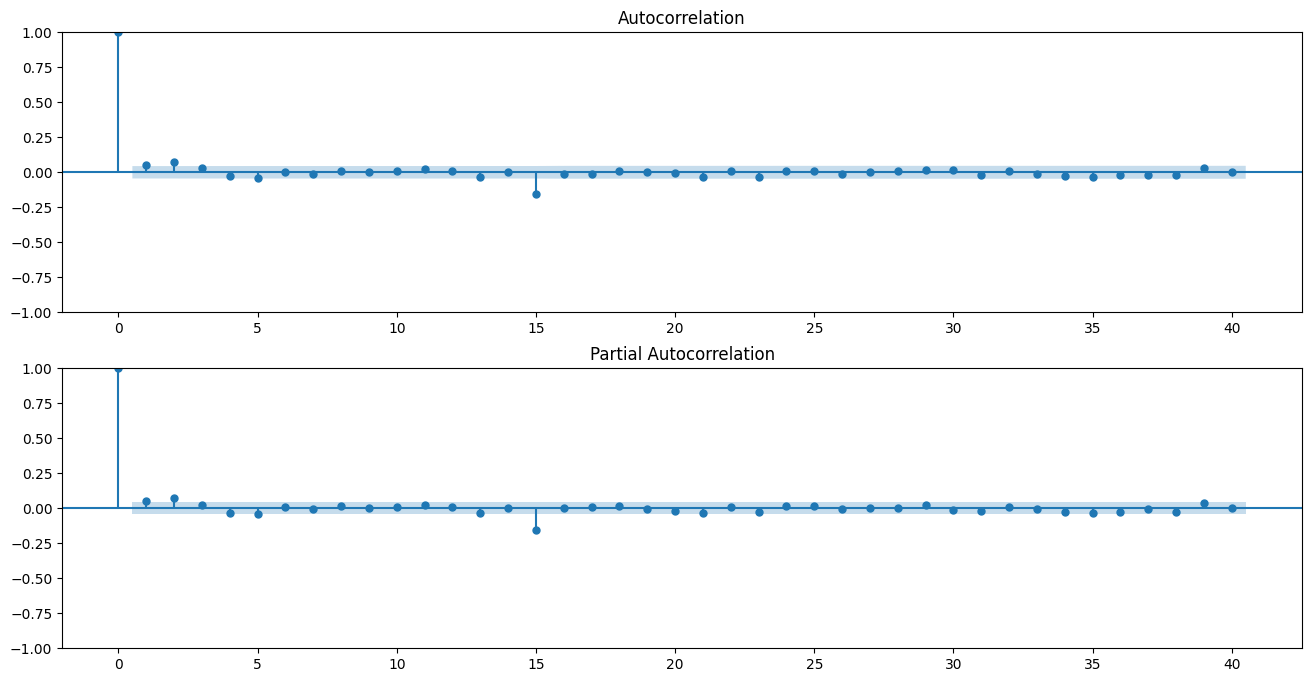

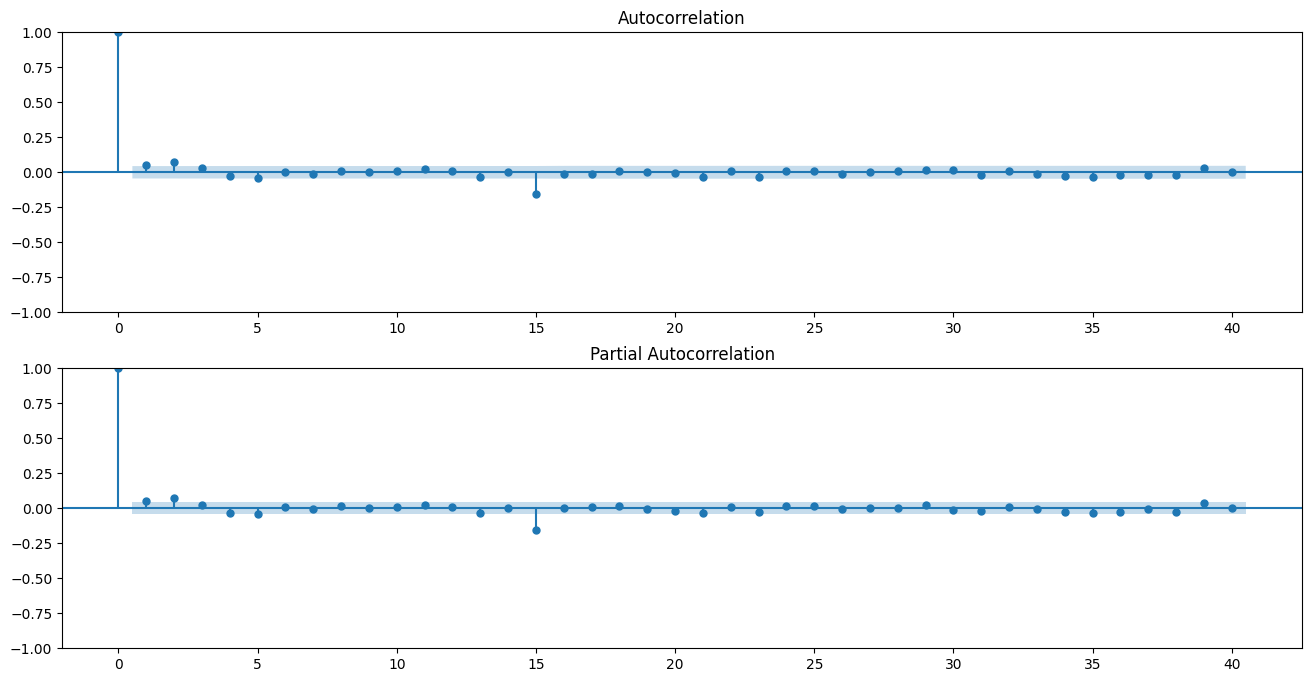

In [33]:
# 정상성 검사
test_autocorrelation(diff)

- ADF 검정의 귀무가설 : 시계열이 정상성이 아니다.
- KPSS 검정의 귀무가설 : 시계열이 정상성이다.
- 위 검정 결과에서 ADF의 귀무가설은 기각, KPSS 검정은 귀무가설을 채택한다.
    - 즉, **차분된 주기는 정상성임을 나타낸다.**

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
# ARIMA 시계열 모델에 가장 적합한 모델을 자동으로 적합

import pmdarima as pm

auto_model = pm.auto_arima(df_train,
                      error_action='ignore',
                      suppress_warnings=True,
                      seasonal=False) # 잠재적 계절성 제외

auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1469
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -11663.807
Date:                Thu, 08 Jun 2023   AIC                          23337.614
Time:                        13:48:01   BIC                          23364.072
Sample:                             0   HQIC                         23347.481
                               - 1469                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2668      0.267     -1.000      0.317      -0.790       0.256
ar.L2          0.6526      0.272      2.396      0.017       0.119       1.186
ma.L1          0.2929      0.278      1.054      0.292      -0.252       0.838
ma.L2         -0.5911      0.289     -2.046      0.041      -1.157      -0.025
sigma2      4.664e+05   2523.025    184.858      0.000    4.61e+05    4.71e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):           1508544.01
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             1.84
Prob(H) (two-sided):                  0.13   Kurtosis:                       160.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
auto_model

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [36]:
# ARIMA 시계열 모델에 가장 적합한 모델을 자동으로 적합

model2 = pm.auto_arima(df_train,
                      error_action='ignore',
                      suppress_warnings=True,
                      seasonal=False, # 잠재적 계절성 제외
                       stepwise=False,
                       approximation=False,
                       n_jobs=-1,
                       m=1) 

model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1469
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -11663.744
Date:                Thu, 08 Jun 2023   AIC                          23339.488
Time:                        13:48:19   BIC                          23371.237
Sample:                             0   HQIC                         23351.328
                               - 1469                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      7.5864     17.395      0.436      0.663     -26.507      41.680
ar.L1         -0.2774      0.282     -0.982      0.326      -0.831       0.276
ar.L2          0.6425      0.291      2.205      0.027       0.071       1.213
ma.L1          0.3037      0.294      1.031      0.302      -0.274       0.881
ma.L2         -0.5810      0.309     -1.882      0.060      -1.186       0.024
sigma2      4.705e+05   2598.819    181.059      0.000    4.65e+05    4.76e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):           1508348.70
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             1.84
Prob(H) (two-sided):                  0.13   Kurtosis:                       159.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- pmdarima 모듈을 이용한 최적의 arima 모델 search를 수행한 결과, **SARIMAX(2, 1, 2)** 가 best model (AIC ⬇)

In [18]:
import seaborn as sns

In [37]:
df_test.index

Index(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
       '2021-01-11', '2021-01-12', '2021-01-13', '2021-01-14', '2021-01-15',
       ...
       '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21', '2022-12-22',
       '2022-12-23', '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29'],
      dtype='object', name='일자', length=494)

In [20]:
df_test

,배출권 가격(종가)
일자,
2021-10-01,31000
2021-10-05,31000
2021-10-06,30000
2021-10-07,29600
2021-10-08,30100
...,...
2022-12-23,14000
2022-12-26,14000
2022-12-27,15000


In [38]:
# 모델 예측
fcast = model2.predict(n_periods = len(df_test))
fcast.index = df_test.index

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
# df_train.index = pd.to_datetime(df_train.index)
# df_test.index = pd.to_datetime(df_test.index)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44428 (\N{HANGUL SYLLABLE GWEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packag

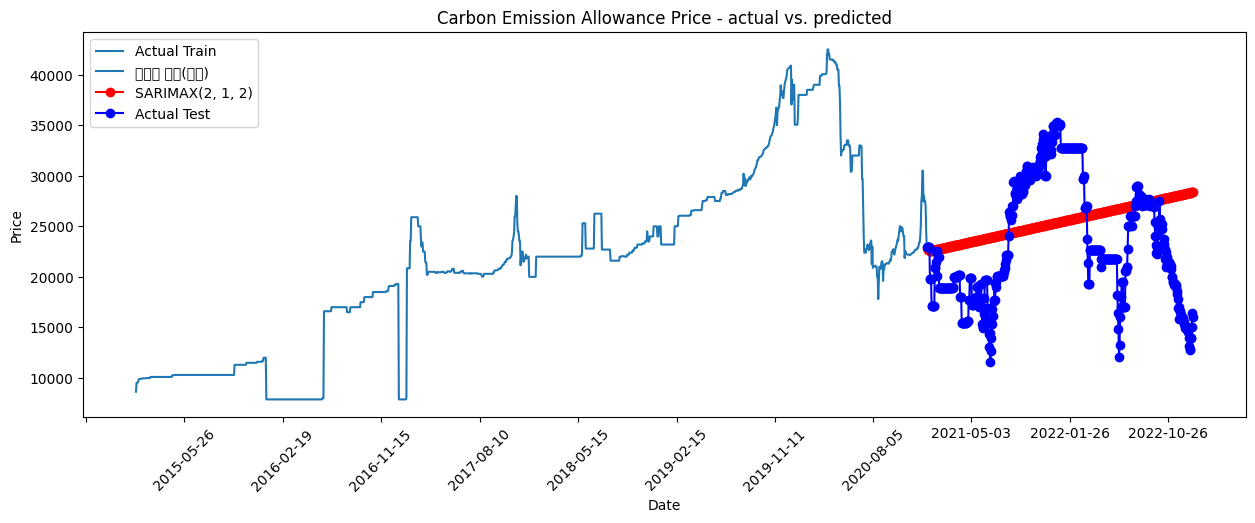

In [39]:
# 예측값 시각화
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(15,5))

ax = sns.lineplot(data=df_train, label='Actual Train')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation=45)
ax.plot(fcast, color='red', marker='o', label='SARIMAX(2, 1, 2)')
ax.plot(df_test, color='blue', marker='o', label='Actual Test')
ax.set(title="Carbon Emission Allowance Price - actual vs. predicted",
             xlabel='Date',
             ylabel='Price')
ax.legend(loc='upper left')

plt.show()

In [25]:
# 성능 평가 

from sklearn.metrics import mean_squared_error
print('The RMSE SARIMAX(2, 1, 2) is :', mean_squared_error(df_test.values, fcast.values)**0.5)

The RMSE SARIMAX(2, 1, 2) is : 9216.466136409685


In [40]:
# 성능 평가 

from sklearn.metrics import mean_squared_error
print('The RMSE SARIMAX(2, 1, 2) is :', mean_squared_error(df_test.values, fcast.values)**0.5)

The RMSE SARIMAX(2, 1, 2) is : 6298.482174655584
